In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import re
from scipy.stats import gmean
import simexpal
import yaml

In [5]:
cfg = simexpal.config_for_dir()

raw_data = []
def parse_fn(run, f):
    match = re.match(r'^(hyperbolic|rmat)-sc(\d+)-', run.instance.shortname)
    if not match:
        return
    assert run.experiment.name.endswith('x2')
    yml = yaml.load(f, Loader=yaml.SafeLoader)
    exp = run.experiment.revision.name
    raw_data.append({
        'exp': exp + '-x2',
        'inst': run.instance.shortname,
        'model': match.group(1),
        'scale': match.group(2),
        'procs': yml['num_procs'] / 2,
        'n': yml['num_nodes'],
        'time': yml['time'],
        'time_phase2': yml.get('mtime_phase2', 0) / 1000,
        'epochs': yml['num_epochs'],
        'samples': yml['num_samples']
    })

cfg.collect_successful_results(parse_fn)
raw_df = pandas.DataFrame(raw_data)

Skipping failed run n16x2/friendster.tf[0]


In [6]:
df = raw_df.copy()
df['time_vertex'] = df['time_phase2'] / df['n'] * 1000000
avg_df = df.groupby(['model', 'scale']).agg({'time_vertex': 'mean'}).sort_index()
avg_df.loc['hyperbolic']

,time_vertex
scale,
23,2.095103
24,2.232492
25,1.519352
26,2.008393


In [7]:
error_df = df.join(avg_df, on=['model', 'scale'], rsuffix='_avg')
error_df['time_vertex'] -= error_df['time_vertex_avg']
min_df = error_df.groupby(['model', 'scale']).agg({'time_vertex': 'min'}).sort_index().abs()
max_df = error_df.groupby(['model', 'scale']).agg({'time_vertex': 'max'}).sort_index().abs()
min_df.loc['hyperbolic']

,time_vertex
scale,
23,0.147939
24,0.353634
25,0.323355
26,0.135645


In [8]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 6}

matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=False)

default_xsize = 1.5

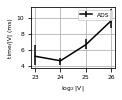

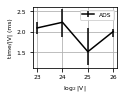

In [10]:
xsize = 1.5
ysize = default_xsize * 0.75

for model in ['rmat', 'hyperbolic']:
    fig, ax = plt.subplots()
    fig.set_size_inches(xsize, ysize)
    plt.xlabel('$\log_2$ |V|')
    plt.ylabel('time/|V| (ms)')
    errors=(min_df.loc[model]['time_vertex'], max_df.loc[model]['time_vertex'])
    plt.errorbar([23, 24, 25, 26], avg_df.loc[model]['time_vertex'], yerr=errors, color='black', label='ADS')
    plt.xticks([23, 24, 25, 26])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.minorticks_off()
    plt.grid()
    plt.legend()
    plt.savefig('gen/synthetic-' + model + '.pdf', format='pdf', bbox_inches = 'tight')
    plt.show()

In [ ]:
avg_df.loc['rmat', '26']['time_vertex'] / avg_df.loc['rmat', '23']['time_vertex']